In [1]:
import sys
import os

# Get Parent folder : 
current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

import pandas as pd
import numpy as np 
import torch
from trainer import Trainer
from K_fold_validation.K_fold_validation import KFoldSplitter
from constants.paths import folder_path,file_name,SAVE_DIRECTORY
from high_level_DL_method import load_model,load_optimizer_and_scheduler

load_config = True
save_folder = 'K_fold_validation'

# If Load config: 
if load_config:
    from examples.load_best_config import load_best_config

    if torch.cuda.is_available():
        trial_id = 'subway_in_STGCN_MSELoss_2024_08_25_18_05_25229'
    else:
        trial_id = 'subway_in_STGCN_MSELoss_2024_08_21_14_50_2810'
    #'subway_in_STGCN_MSELoss_2024_08_25_18_05_25229'
    #'subway_in_calendar_STGCN_MSELoss_2024_08_25_22_56_92429'
    #'netmob_subway_in_STGCN_ImageAvgPooling_MSELoss_2024_08_24_01_42_17375'
    #'netmob_subway_in_STGCN_FeatureExtractor_ResNetInspired_MSELoss_2024_08_23_06_53_46982'
    #'netmob_subway_in_calendar_STGCN_ImageAvgPooling_MSELoss_2024_08_27_00_16_90667'
    #'netmob_subway_in_calendar_STGCN_FeatureExtractor_ResNetInspired_MSELoss_2024_08_28_06_04_41108'
    
    #'subway_in_STGCN_MSELoss_2024_08_21_14_50_2810'
    folder = 'save/HyperparameterTuning'
    args,coverage = load_best_config(trial_id)
    
    #Update modif validation
    args.train_prop = 0.6
    args.valid_prop = 0.2
    args.test_prop = 0.2
    args.ray = False
    args.train_valid_test_split_method = 'iterative_method' # 'similar_length_method' # 'iterative_method'
    
    #Change/Set epochs: 
    args.epochs = 200
    
    dataset_names = args.dataset_names 
    vision_model_name = args.args_vision.model_name if len(vars(args.args_vision))>0 else None

# If new config : 
else:
    from examples.load_random_config import args,coverage,trial_id,dataset_names,vision_model_name,model_name

# If load trial id computed from another laptot
if not torch.cuda.is_available():
    args.abs_path = ('/').join(f"{os.path.abspath(os.getcwd())}".split('/')[:-1]) + '/'

'pynvml' is not available on this environment.


# Sliding Window Cross Validation 
## Define fixed Dataset K_fold split for each trial: 

In [3]:
args.train_valid_test_split_method = 'similar_length_method' # 'similar_length_method' # 'iterative_method'
folds = list(np.arange(args.K_fold))
K_fold_splitter = KFoldSplitter(dataset_names,args,coverage,folder_path,file_name,vision_model_name,folds)
K_subway_ds,dic_class2rpz,args = K_fold_splitter.split_k_fold()

Time-step per hour: 4.0
coverage period: 2019-03-16 00:00:00 - 2019-05-31 23:45:00

Init Subway-In Dataset:  torch.Size([7392, 40])
Number of Nan Value:  tensor(0)
Total Number of Elements:  295680 

>>> Train/Valid/Test split method : similar_length_method

U size:  torch.Size([6719, 40, 7]) Utarget size:  torch.Size([6719, 40, 1])
U_train size:  torch.Size([4031, 40, 7]) Utarget_train size:  torch.Size([4031, 40, 1])
U_valid size:  torch.Size([1344, 40, 7]) Utarget_valid size:  torch.Size([1344, 40, 1])
U_test size:  torch.Size([1343, 40, 7]) Utarget_test size:  torch.Size([1343, 40, 1])
U_train min:  tensor(0.) U_train max:  tensor(10798.)
U_valid min:  tensor(0.) U_valid max:  tensor(1788.)
U_test min:  tensor(0.) U_test max:  tensor(1760.)

Fold n°0
Time-step per hour: 4.0
coverage period: 2019-03-17 00:15:00 - 2019-04-13 11:30:00

Init Subway-In Dataset:  torch.Size([2638, 40])
Number of Nan Value:  tensor(0)
Total Number of Elements:  105520 

>>> Train/Valid/Test split method :

## K-fold split Plotting if necessary: 

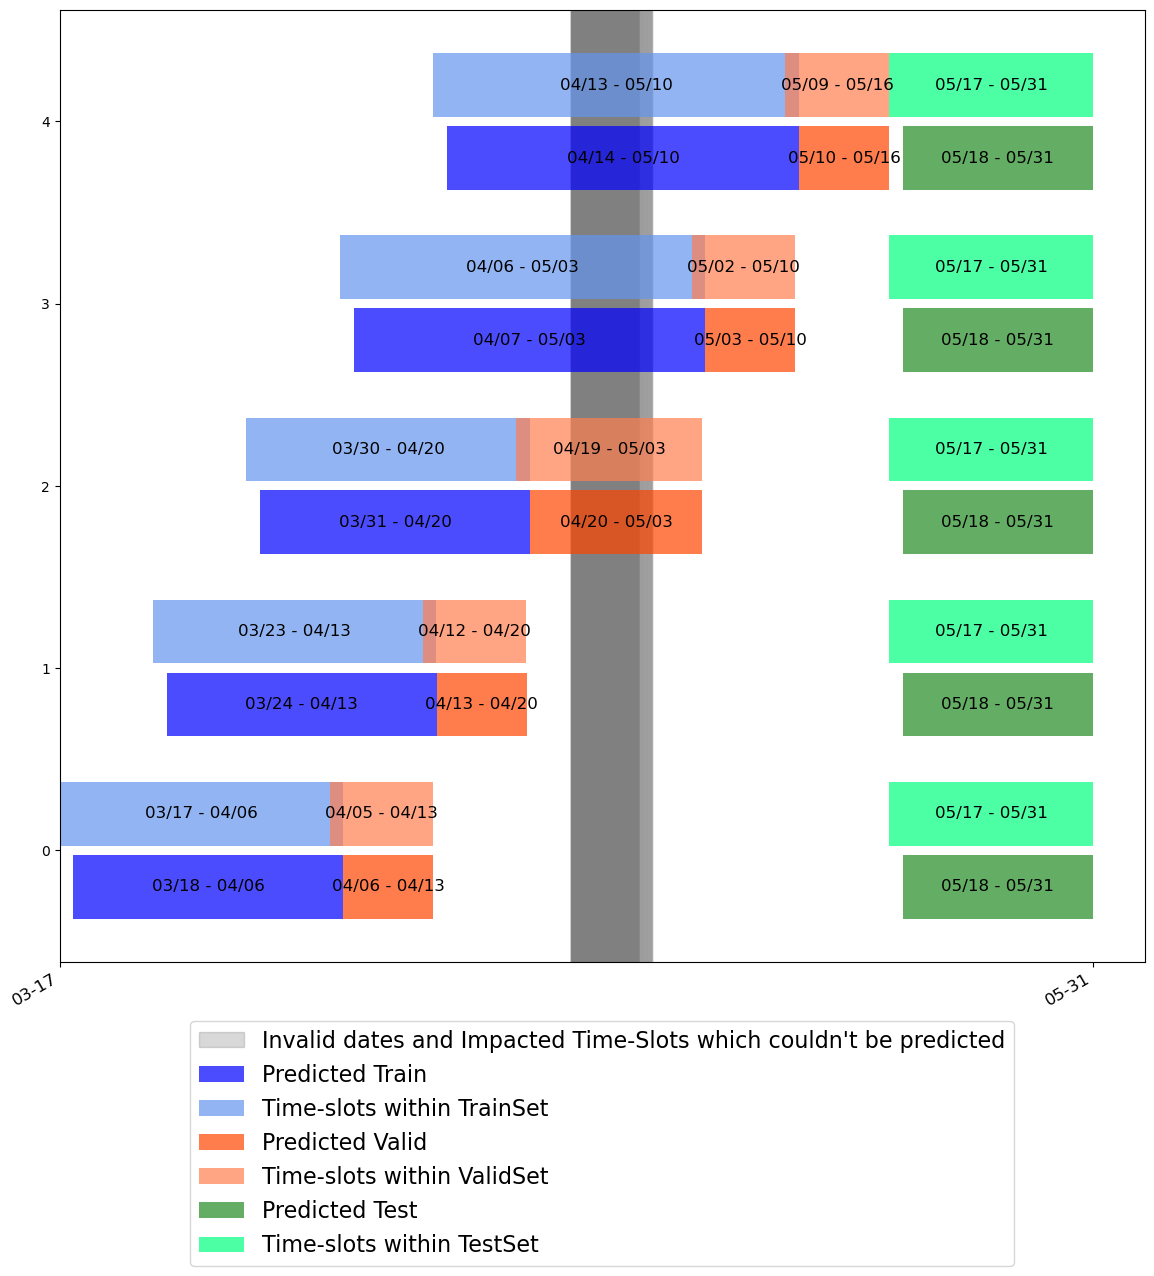

In [4]:
from plotting.plotting import plot_k_fold_split
plot_k_fold_split(K_subway_ds,K_subway_ds[0].init_invalid_dates)

## Check Number of predicted day in validation set: 

In [ ]:
for i in range(args.K_fold):
    dset = K_subway_ds[i]
    limits = dset.tensor_limits_keeper
    display(limits.df_verif_valid['t+0'].dt.date.value_counts())

## Split Tuning and Validation datasets:

In [4]:
ds_tuning = K_subway_ds[0]
ds_validation = K_subway_ds[1:]

## Train on the K-1 folds:

In [5]:
valid_losses = []
for fold,ds in enumerate(ds_validation):
    model = load_model(args,dic_class2rpz)
    optimizer,scheduler,loss_function = load_optimizer_and_scheduler(model,args)
    trainer = Trainer(ds,model,args,optimizer,loss_function,scheduler = scheduler,dic_class2rpz = dic_class2rpz,show_figure = False,fold=fold,save_folder = save_folder)
    trainer.train_and_valid(mod = 1000,mod_plot = None) 
    valid_losses.append(trainer.performance['valid_loss'])

## Save Model: 
row = {f"fold{k}": [loss] for k,loss in enumerate(valid_losses)}
row.update({'mean' : [np.mean(valid_losses)]})
df_results = pd.DataFrame.from_dict(row)
df_results.to_csv(f"{SAVE_DIRECTORY}/{save_folder}/VALID_{trial_id}.csv")

Model size: 0.000GB
number of total parameters: 4
number of trainable parameters: 4

start training


/Users/romainrochas/opt/anaconda3/envs/preprocessingclone/lib/python3.7/site-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
/Users/romainrochas/opt/anaconda3/envs/preprocessingclone/lib/python3.7/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 0 
 min\epoch : 0.02
Estimated time for training: 0.1min 
Training Throughput:3278.27 sequences per seconds
>>> Training complete in: 0:00:08.614024
>>> Training performance time: min 0.008652687072753906 avg 0.009569168090820312 seconds (+/- 0.0002687663403319963)
>>> Loading performance time: min 0.0001418590545654297 avg 0.006269339232416878 seconds (+/- 0.016083101341490737)
>>> Forward performance time: 0.004888151460965006 seconds (+/- 0.0001794107955518619)
>>> Backward performance time: 0.004706347638272045 seconds (+/- 0.00015803939227106628)
>>> Plotting performance time: 1.0251998901367188e-05 seconds (+/- 2.327076070266357e-05)
>>> Saving performance time: 0.0016219615936279297 seconds (+/- 5.058723139040159e-05)
>>> PI-tracking performance time: 2.3312038845486113e-06 seconds (+/- 5.123106534166791e-07)
>>> Scheduler-update performance time: 3.96569569905599e-05 seconds (+/- 7.273395022486084e-06)
>>> Validation time: 0:00:00.166119
Proportion of time consumed for L